El primer modelo que se probara sera un RNN basico.
Para todos los modelos se usaran basicamente los mismos parametros, con el bert tokenizer, debido a su gran popularidad y efectividad
demostrada, asi como Adam de optimizador, y Cross entropy loss, al ser una de las mas comunes.

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

dataset = load_dataset('imdb')

def reduce_dataset(dataset, factor=10):
    reduced_dataset = {}
    for split in dataset.keys():
        labels = np.array(dataset[split]['label'])
        num_per_class = (len(labels) // (2 * factor))
        
        # Get indices for each class
        indices_0 = np.where(labels == 0)[0][:num_per_class]
        indices_1 = np.where(labels == 1)[0][:num_per_class]
        
        # Combine and shuffle indices
        indices = np.concatenate([indices_0, indices_1])
        np.random.shuffle(indices)
        
        # Select the subset
        reduced_dataset[split] = dataset[split].select(indices.tolist())
    return reduced_dataset

reduced_dataset = reduce_dataset(dataset)

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

tokenized_datasets = {}
for split in reduced_dataset.keys():
    tokenized_datasets[split] = reduced_dataset[split].map(tokenize_function, batched=True)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids):
        embedded = self.dropout(self.embedding(input_ids))
        output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = RNNClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return input_ids, labels

train_loader = DataLoader(tokenized_datasets['train'], batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(tokenized_datasets['test'], batch_size=8, shuffle=False, collate_fn=collate_fn)

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for input_ids, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, labels in test_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return total_loss / len(test_loader), accuracy, precision, recall, f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

torch.save(model.state_dict(), './trained_rnn_model.pt')
tokenizer.save_pretrained('./trained_rnn_model')

def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    input_ids = inputs['input_ids']
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        predicted_class = torch.argmax(outputs, dim=1).item()
    return predicted_class


text = "This movie was fantastic! I really enjoyed it."
prediction = predict(text)
print(f'Predicted class: {prediction}')

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Epoch 1/3
Train Loss: 0.7065
Validation Loss: 0.6944
Accuracy: 0.5044
Precision: 0.5274
Recall: 0.0848
F1 Score: 0.1461
Epoch 2/3
Train Loss: 0.7016
Validation Loss: 0.6900
Accuracy: 0.5440
Precision: 0.5658
Recall: 0.3784
F1 Score: 0.4535
Epoch 3/3
Train Loss: 0.6925
Validation Loss: 0.6945
Accuracy: 0.5012
Precision: 0.6154
Recall: 0.0064
F1 Score: 0.0127
Predicted class: 0


In [19]:
#epochs 3-6
num_epochs = 3
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

Epoch 1/3
Train Loss: 0.7050
Validation Loss: 0.6932
Accuracy: 0.5076
Precision: 0.5259
Recall: 0.1544
F1 Score: 0.2387
Epoch 2/3
Train Loss: 0.6971
Validation Loss: 0.6957
Accuracy: 0.5028
Precision: 0.5014
Recall: 0.9880
F1 Score: 0.6652
Epoch 3/3
Train Loss: 0.6945
Validation Loss: 0.6935
Accuracy: 0.4956
Precision: 0.4975
Recall: 0.8928
F1 Score: 0.6390


No tiene mucho sentido revisar mas sobre el modelo casi con resultados asi. Una prediccion aleatoria o todas de un label,
tendria mejor o igual precision. Se veran los grafos, para evaluar si existe algun problema en sus losses.
No se realizaron mas epochs, al ver que la precision despues de 3 epochs y muchas horas de entreno eran tan pesima.
Se continuara con su version mejorada, el LSTM.

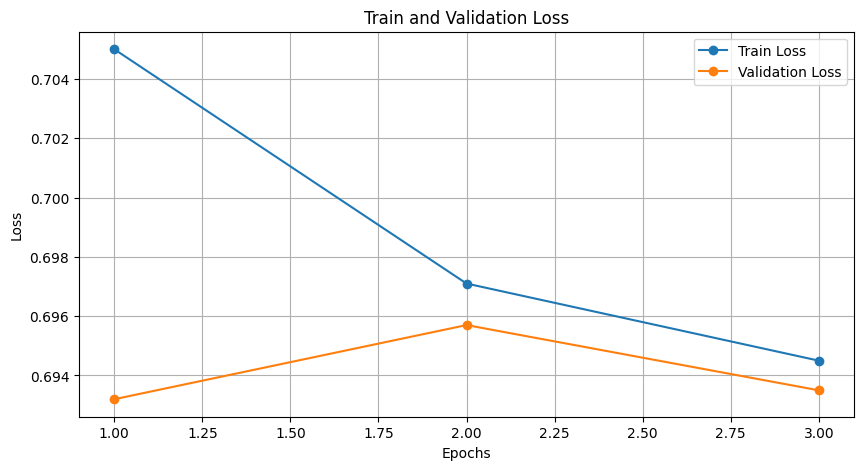

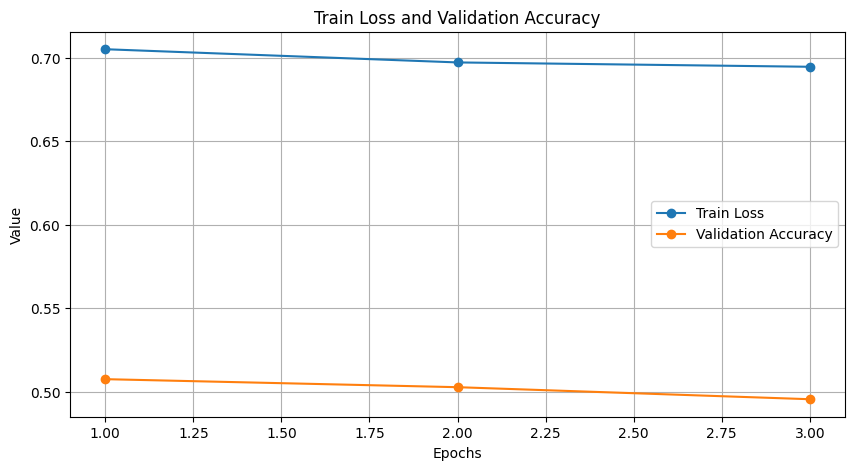

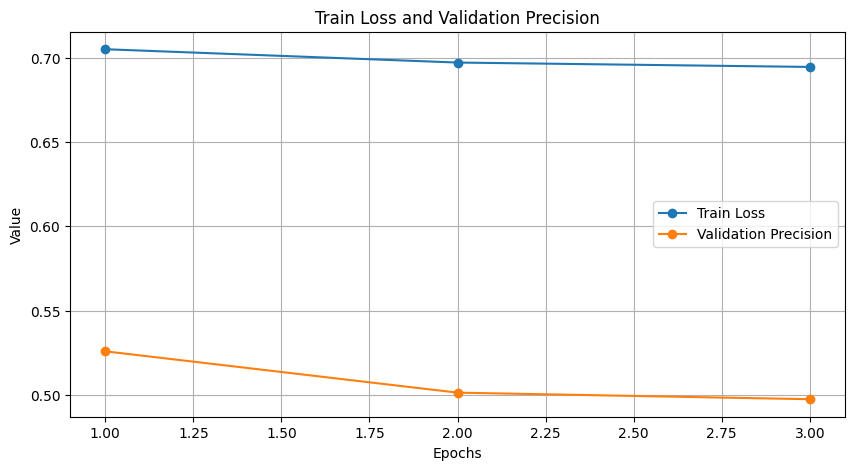

In [22]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3]
train_loss = [0.7050, 0.6971, 0.6945]
val_loss = [0.6932, 0.6957, 0.6935]
accuracy = [0.5076, 0.5028, 0.4956]
precision = [0.5259, 0.5014, 0.4975]
recall = [0.1544, 0.9880, 0.8928]
f1_score = [0.2387, 0.6652, 0.6390]

# Plotting Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Train Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Train Loss and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Train Loss and Precision
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, precision, label='Validation Precision', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Train Loss and Validation Precision')
plt.legend()
plt.grid(True)
plt.show()

No hace falta mucho comentario, de alguna manera la precision va bajando junto a su train loss,
con una clara muestra tambien de futuro sobreentreno con la bajada de el train loss en comparacion con su validation loss.

In [20]:
torch.save(model.state_dict(), './trained_rnn_model.pt')
tokenizer.save_pretrained('./trained_rnn_model')

('./trained_rnn_model\\tokenizer_config.json',
 './trained_rnn_model\\special_tokens_map.json',
 './trained_rnn_model\\vocab.txt',
 './trained_rnn_model\\added_tokens.json')